In [1]:
library(tidyverse)

library(treemap)
library(ggplotify)
theme_set(theme_minimal())
library(wesanderson)
library(MetBrewer)

# fix problems with cyrillics
library(extrafont)
library(showtext)
font_add("Arial", "/Library/Fonts/Arial.ttf") 
showtext_auto()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'MetBrewer':
  method        from       
  print.palette wesanderson

Registering fonts with R

Ładowanie wymaganego pakietu: sysfonts

Ładowanie wymaganego pakietu: showtextdb


Dołączanie pakietu: ‘showtextdb’


Następujący obiekt został zakryty z ‘package:extrafont’:

    font_install




[1] "Archambault" "Cassatt1"    "Cassatt2"    "Demuth"      "Derain"     
 [6] "Egypt"       "Greek"       "Hiroshige"   "Hokusai2"    "Hokusai3"   
[11] "Ingres"      "Isfahan1"    "Isfahan2"    "Java"        "Johnson"    
[16] "Kandinsky"   "Morgenstern" "OKeeffe1"    "OKeeffe2"    "Pillement"  
[21] "Tam"         "Troy"        "VanGogh3"    "Veronese"

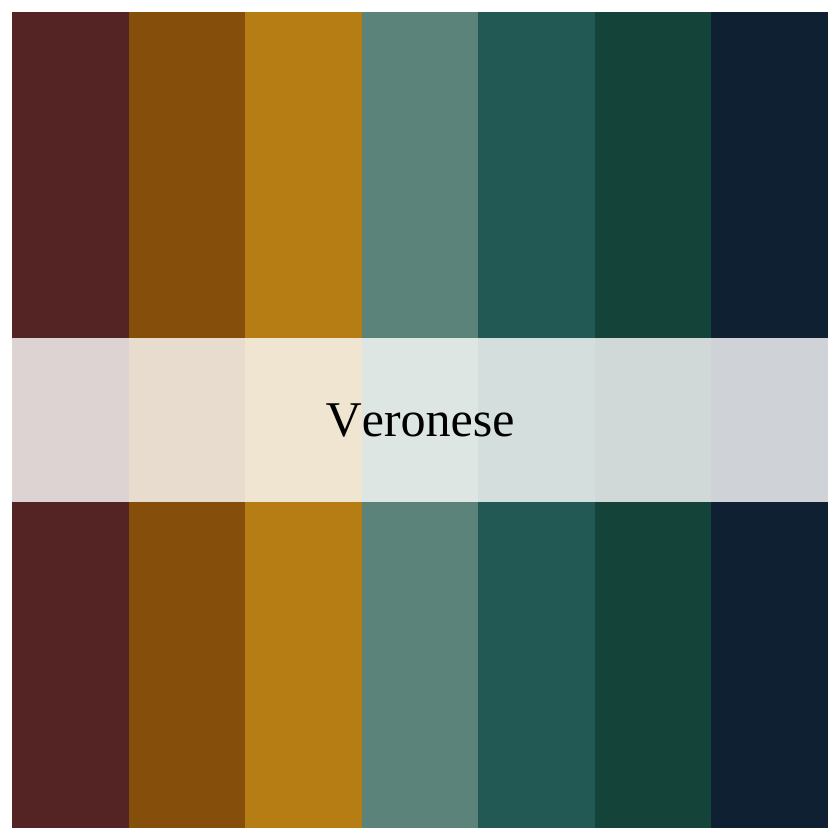

In [2]:
MetBrewer::colorblind_palettes

met.brewer(MetBrewer::colorblind_palettes[24])

## Data compilation

Load full metadata

In [ ]:
per_full <- read.delim("../../meta/periodicals_texts.tsv", sep = "\t")
glimpse(per_full)

Attach texts and fill the column for text existence

In [ ]:
# lf <- list.files(path = "../../data/periodicals/periodicals_united/",
#                  full.names = T)
# 
# per_texts <- tibble(text_ID = str_remove_all(lf,
#                                 "../../data/periodicals/periodicals_united//|\\.txt"),
#        text_done = "1",
#        text_raw = sapply(lf, read_file))
# 
# glimpse(per_texts)
# 
# per_texts <- per_texts %>% 
#   mutate(text_lemm = str_remove_all(text_raw, "<.*?>"))
# 
# write.csv(per_texts, file = "per.csv")

In [ ]:
per_texts <- read.csv("../../data/periodicals_texts.csv") %>% 
                  select(-X) %>% 
                  mutate(text_ID = str_remove(text_ID, "\\.tx"))
glimpse(per_texts)

Attach authors data

In [ ]:
authors <- read.delim("../../meta/authors.tsv", sep = "\t")
glimpse(authors)

Combine all data together

In [ ]:
per <- per_full %>% 
  select(-txt_raw, -text) %>% 
  left_join(per_texts, by = "text_ID") %>% 
  left_join(authors %>% rename(author_x = author), by = "A_ID") %>% 
  # for poems with authors not in authors_meta add author == author_sign
  mutate(author = ifelse((A_ID == "" & author == ""), author_sign, author))

glimpse(per)

# save(per, file = "periodicals_full_data.Rda")

## Data load

In [3]:
load("periodicals_full_data.Rda")
glimpse(per)

print(c("Number of texts:", per %>% filter(text_raw != "") %>% nrow))

Rows: 1,877
Columns: 31
$ text_ID                 <chr> "P_1834", "P_10", "P_11", "P_12", "P_13", "P_1…
$ nkrja_id                <int> NA, 1232, NA, NA, 12698, NA, NA, NA, 12683, NA…
$ nkrja_author            <chr> "", "Л. А. Якубович", "", "", "А. С. Пушкин", …
$ A_ID                    <chr> "A-152", "A-50", "A-138", "A-139", "A-11", "A-…
$ author                  <chr> "Красов В.И.", "Якубович Л.А.", "Кутайсов А.И.…
$ text_title              <chr> "Паж Генриха Второго", "Молния", "Аполог", "По…
$ first_line              <chr> "Он умер внезапно уж Генрих Второй", "Зачем с …
$ PER_ID                  <chr> "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ…
$ year                    <int> 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835…
$ vol                     <chr> "Т. 35", "Т.8. Отд. 1", "Т.8. Отд. 1", "Т.8. О…
$ num                     <chr> "", "", "", "", "", "", "", "", "", "", "", ""…
$ pages                   <chr> "10-12", "21", "22", "145-157", "158", "159", …
$ subtitle      

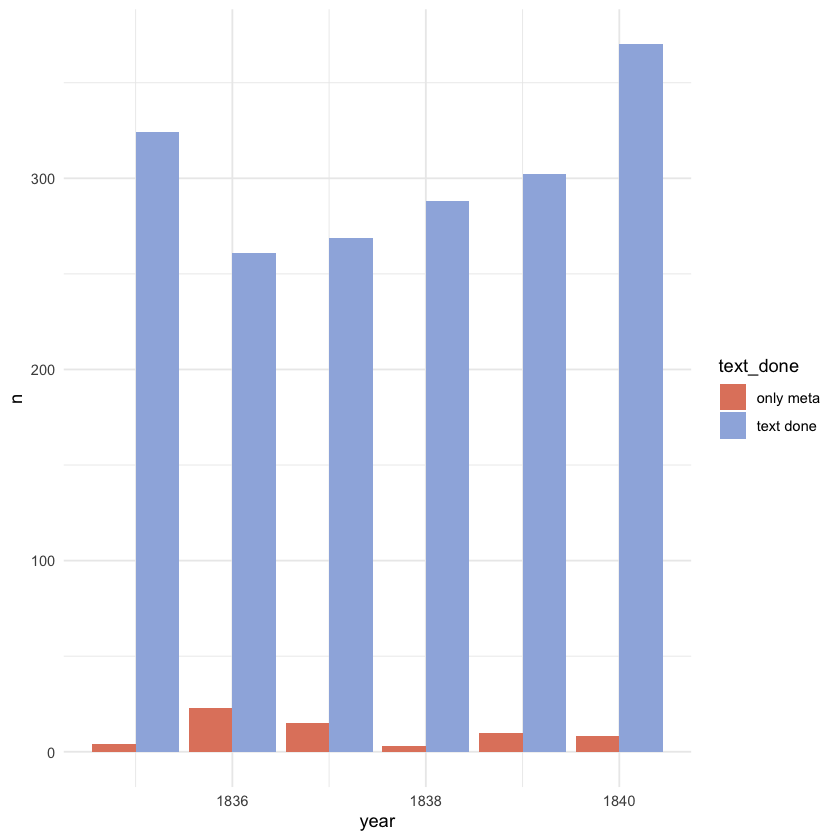

In [4]:
per %>% 
  mutate(text_done = ifelse(!is.na(text_raw), "text done", "only meta")) %>% 
  count(year, text_done) %>% 
  ggplot(aes(x = year, y = n, fill = text_done)) + 
  geom_col(position = "dodge") + 
  scale_fill_manual(values = met.brewer("NewKingdom")[1:3])

In [5]:
# RNC data
load("../../data/nkrja_19th_lem.Rda")

rnc_authors <- c19 %>% 
    select(author) %>% 
    mutate(author = str_remove_all(author, "[[:space:]]|[[:punct:]]")) %>% 
    distinct() %>% 
    pull()

head(rnc_authors)

#rm(c19)

[1] "ССБобров"    "САТучков"    "ССПестов"    "ППСумароков" "НССмирнов"  
[6] "ПАСловцов"

## 2.1. Periodicals vs RNC

Comparison on number of authors

In [6]:
print("Total number of authors in periodicals:")
per %>% 
    filter(A_ID != "" & author != "") %>% # 1455 poems are with known author
    select(author) %>% 
    count(author, sort = T) %>% nrow() 

print("Number of authors with biography in RP:")
per %>% 
    filter(RP != "") %>% # 1198 poems by authors known by RP
    select(RP) %>% 
    count(RP, sort = T) %>% nrow() 

print("Number of authors included in RNC")
per %>% 
    filter(author != "") %>% 
    select(author) %>% 
    mutate(author = str_replace_all(author, 
                                    "(.*?[[:space:]])(\\w\\.\\w.)", 
                                    "\\2\\1")) %>% 
    mutate(author = str_remove_all(author, "[[:space:]]|[[:punct:]]")) %>% 
    distinct() %>% 
    filter(author %in% rnc_authors) %>% 
    nrow()

[1] "Total number of authors in periodicals:"


[1] 187

[1] "Number of authors with biography in RP:"


[1] 128

[1] "Number of authors included in RNC"


[1] 58

### Textual intersections between RNC & periodicals

-   Create for each poem an id column containing two first lines
-   Mark the intersection with a special tag

In [7]:
periodicals <- per %>% 
    mutate(doublesCheck = str_extract(text_lemm, "^.*?\n.*?\n.*?\n")) %>% 
    mutate(doublesCheck = str_remove_all(doublesCheck, "[[:punct:]]|[[:space:]]")) %>% 
    filter(text_raw != "") # remove empty lines

glimpse(periodicals)

Rows: 1,814
Columns: 32
$ text_ID                 <chr> "P_1834", "P_10", "P_11", "P_12", "P_13", "P_1…
$ nkrja_id                <int> NA, 1232, NA, NA, 12698, NA, NA, NA, 12683, NA…
$ nkrja_author            <chr> "", "Л. А. Якубович", "", "", "А. С. Пушкин", …
$ A_ID                    <chr> "A-152", "A-50", "A-138", "A-139", "A-11", "A-…
$ author                  <chr> "Красов В.И.", "Якубович Л.А.", "Кутайсов А.И.…
$ text_title              <chr> "Паж Генриха Второго", "Молния", "Аполог", "По…
$ first_line              <chr> "Он умер внезапно уж Генрих Второй", "Зачем с …
$ PER_ID                  <chr> "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ…
$ year                    <int> 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835…
$ vol                     <chr> "Т. 35", "Т.8. Отд. 1", "Т.8. Отд. 1", "Т.8. О…
$ num                     <chr> "", "", "", "", "", "", "", "", "", "", "", ""…
$ pages                   <chr> "10-12", "21", "22", "145-157", "158", "159", …
$ subtitle      

In [8]:
nkrja19 <- c19 %>% 
    rename(index = `Unnamed..0`,
          text_lemm = lemma) %>% 
    select(index, author, text_lemm) %>%
    mutate(doublesCheck = str_extract(text_lemm, "^.*?\n.*?\n.*?\n")) %>% 
    mutate(doublesCheck = str_remove_all(doublesCheck, "[[:punct:]]|[[:space:]]"))

glimpse(nkrja19)

Rows: 15,569
Columns: 4
$ index        <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…
$ author       <chr> "С. С. Бобров", "С. С. Бобров", "С. С. Бобров", "С. С. Бо…
$ text_lemm    <chr> "еще вкруг солнцев не вращаться \n в превыспренний страна…
$ doublesCheck <chr> "ещевкругсолнцевневращатьсявпревыспреннийстранамирещевхао…


In [9]:
doubles_id <- periodicals %>% 
    inner_join(nkrja19, by = "doublesCheck") %>% 
    select(index, text_ID, year, author.x, author.y, doublesCheck, text_raw)

doubles_id %>% select(-text_raw) %>% head

,index,text_ID,year,author.x,author.y,doublesCheck
,<int>,<chr>,<int>,<chr>,<chr>,<chr>
1,1232,P_10,1835,Якубович Л.А.,Л. А. Якубович,зачемснебесныйвысотаизгорнийжильеналонобурямчатьсяты
2,12698,P_13,1835,Пушкин А.С.,А. С. Пушкин,чтотыржатьмойконьретивыйчтотышеяопускатьнепотряхиватьгрива
3,5661,P_16,1835,Грибоедов А.С.,А. С. Грибоедов,живойлиямертвыйлияичтозачудныйвидение
4,12683,P_17,1835,Пушкин А.С.,А. С. Пушкин,корольходитьбольшойшагвзадивпередпопалатачеловекспатькорольлишьнеспаться
5,12684,P_18,1835,Пушкин А.С.,А. С. Пушкин,чтовразъездбитьянкомарнавиччтоондоманесидетьсяотчегодваночьонсряду
6,11777,P_1837,1835,С.,А. И. Полежаев,


In [10]:
print("Total number of intersected texts:")
nrow(doubles_id)

print("Total number of texts in periodicals:")
nrow(periodicals)

print("Total % of intersected texts out for all periodicals texts:")
round( (nrow(doubles_id)/nrow(periodicals))*100 , 1) 

[1] "Total number of intersected texts:"


[1] 326

[1] "Total number of texts in periodicals:"


[1] 1814

[1] "Total % of intersected texts out for all periodicals texts:"


[1] 18

In [11]:
glimpse(doubles_id)

doubles_counts <- doubles_id %>% 
    count(year) %>% 
    mutate(group = "Периодика и НКРЯ")

doubles_counts %>% pivot_wider(names_from = year, values_from = n)

Rows: 326
Columns: 7
$ index        <int> 1232, 12698, 5661, 12683, 12684, 11777, 12685, 12687, 126…
$ text_ID      <chr> "P_10", "P_13", "P_16", "P_17", "P_18", "P_1837", "P_19",…
$ year         <int> 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835, 183…
$ author.x     <chr> "Якубович Л.А.", "Пушкин А.С.", "Грибоедов А.С.", "Пушкин…
$ author.y     <chr> "Л. А. Якубович", "А. С. Пушкин", "А. С. Грибоедов", "А. …
$ doublesCheck <chr> "зачемснебесныйвысотаизгорнийжильеналонобурямчатьсяты", "…
$ text_raw     <chr> "Зачем с небесной высоты, \nИз горнего жилья, \nНа лоне б…


group,1835,1836,1837,1838,1839,1840
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
Периодика и НКРЯ,48,66,50,46,49,67


### Plot 2.2.1

In [12]:
rnc_1835 <- c19 %>% 
    rename(index = `Unnamed..0`) %>% 
    # remove intersection
    #anti_join(doubles_id %>% select(index), by = "index") %>%

    # calculate number of unique poems
    filter(year > 1834 & year < 1841) %>% 
    count(year, sort = F) %>% 
    mutate(group = "НКРЯ")

rnc_1835 %>% pivot_wider(names_from = year, values_from = n)

group,1835,1836,1837,1838,1839,1840
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
НКРЯ,196,149,180,146,238,303


In [13]:
counter_1835 <- per %>% 
    # remove intersection
    #anti_join(doubles_id %>% select(id), by = "id") %>%

    count(year, sort = F) %>% 
    mutate(group = "Периодика") %>%
    rbind(rnc_1835, doubles_counts)

counter_1835 %>% pivot_wider(names_from = year, values_from = n)

group,1835,1836,1837,1838,1839,1840
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
Периодика,328,284,284,291,312,378
НКРЯ,196,149,180,146,238,303
Периодика и НКРЯ,48,66,50,46,49,67


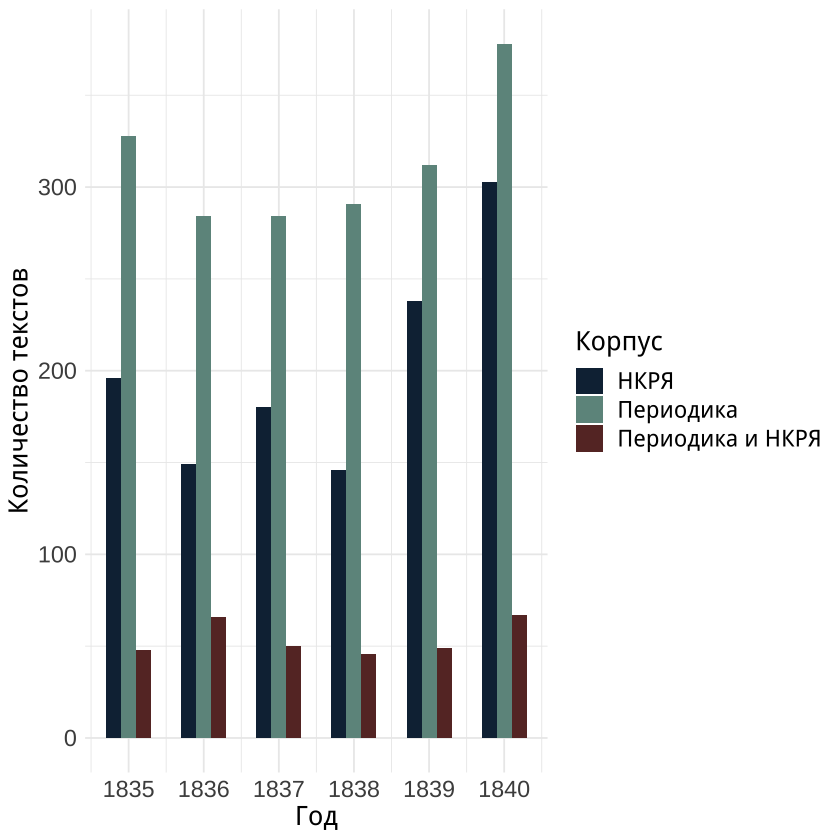

In [16]:
p2_2_1 <- counter_1835 %>%
    ggplot(aes(x = year, y = n, fill = group)) + 
    geom_col(position = "dodge", width = 0.6) + 
    scale_fill_manual(values = c(met.brewer("Veronese")[7], # dark blue
                                 met.brewer("Veronese")[4], # light blue
                                 met.brewer("Veronese")[1] # dark red
                                )) + 
    scale_x_continuous(breaks = 1835:1840) +
    theme(axis.text = element_text(size = 14),
         axis.title = element_text(size = 16),
         legend.title = element_text(size = 16, face = "bold"),
         legend.text = element_text(size = 14)) + 
    labs(x = "Год",
        y = "Количество текстов",
        fill = "Корпус")

p2_2_1

In [ ]:
# ggsave(file = "plots/fig2_2_1.png", plot = p2_2_1, dpi = 300,
#       width = 8, height = 6, bg = "white")

## 2.2.1. Sources statistics

Analysis of poems published in different sources (journals & newspapers) and by different authors

In [ ]:
glimpse(per)

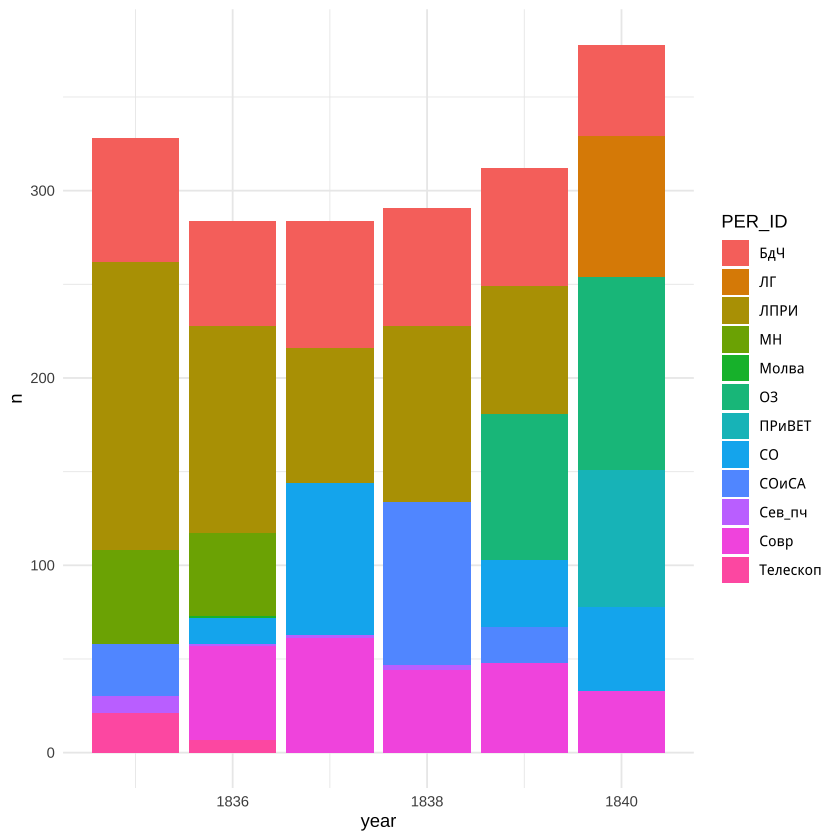

In [18]:
per %>% group_by(year, PER_ID) %>% count() %>% 
    ggplot(aes(x = year, y = n, fill = PER_ID)) + geom_col() 

### Plots 2.2.2

In [19]:
periodicals <- per %>% 
  filter(!PER_ID %in% c("Молва", "МН", "Сев_пч"))

years_total <- periodicals %>% 
  count(year) %>% 
  mutate(year_label = paste0(year, " (N = ", n, ")"))

source_year_total <- periodicals %>% 
  count(PER_ID, year)

In [20]:
authors_sources <- periodicals %>% 
    #filter(PER_ID != "Сев_пч") %>% 
    mutate(PER_ID = ifelse(str_detect(PER_ID,"СОиСА"), "СО", PER_ID)) %>% 
    filter(author != "") %>% 
    
    # grouping by author, year and source
    group_by(year, PER_ID, author) %>% 
    count(sort = T) %>% 
    ungroup() %>%
    
    # non-frequent authors grouped as "others"
    mutate(author = ifelse(n < 3, "Другие", author)) %>% 
    group_by(year, PER_ID, author) %>% 
    # sum poems by others
    summarise(n = sum(n)) %>% 
    mutate(author_label = paste0(author, " (", n, ")"))

head(authors_sources)

`summarise()` has grouped output by 'year', 'PER_ID'. You can override using
the `.groups` argument.


year,PER_ID,author,n,author_label
<int>,<chr>,<chr>,<int>,<chr>
1835,БдЧ,Другие,29,Другие (29)
1835,БдЧ,Ершов П.П.,6,Ершов П.П. (6)
1835,БдЧ,Козлов И.И.,11,Козлов И.И. (11)
1835,БдЧ,Пушкин А.С.,16,Пушкин А.С. (16)
1835,БдЧ,Якубович Л.А.,3,Якубович Л.А. (3)
1835,ЛПРИ,13 — 18.,3,13 — 18. (3)


In [ ]:
MetBrewer::colorblind_palettes

met.brewer("Archambault")

met.brewer("Egypt")

met.brewer("Johnson")

met.brewer("Kandinsky")

met.brewer("Veronese")

In [ ]:
# treemap: https://cran.r-project.org/web/packages/treemap/treemap.pdf

x <- NULL

for (i in 1:length(unique(per_full$year))) {
    
    x <- unique(per_full$year)[i]
    
    filename = paste0("plots/treemaps/plot_", x, ".png")

    png(filename, width = 600, height = 600)

    t <- authors_sources %>% 
        filter(year == x) %>% 
        treemap(
            index = c("PER_ID", "author_label"),
            vSize = "n",
            type = "index",
            palette = light_palette,
            fontsize.labels = c(20, 16),
            #position.legend = "right",
            overlap.labels = 1,
            title = x,
            fontsize.title = 22
        )

    dev.off()
}

In [ ]:
years_total

In [ ]:
source_year_total %>% arrange(-desc(year))

In [ ]:
png("plots/treemaps/2-2-2_1835_v2.png", height = 650, width = 600)

tree_pal <- c(met.brewer("Veronese")[1], # BdCH
              met.brewer("Veronese")[3], # LPRI
              met.brewer("Veronese")[4], # SO
              met.brewer("Kandinsky")[3]) # Telescop

authors_sources %>% 
        filter(year == 1835) %>% 
        treemap(
            index = c("PER_ID", "author_label"),
            vSize = "n",
            type = "index",
            palette = tree_pal,
            fontsize.labels = c(24, 16),
            #position.legend = "right",
            overlap.labels = 1,
            title = "1835 (N = 269)",
            fontsize.title = 22
        )

dev.off()

In [ ]:
png("plots/treemaps/2-2-2_1836_v2.png", height = 650, width = 600)

authors_sources %>% 
        filter(year == 1836) %>% 
        select(PER_ID) %>% distinct() %>% arrange(-desc(PER_ID))

tree_pal <- c(met.brewer("Veronese")[1], # BdCH
              met.brewer("Veronese")[3], # LPRI
              met.brewer("Veronese")[4], # SO
              met.brewer("Veronese")[7], # Sovr
              met.brewer("Kandinsky")[3]) # Telescop

authors_sources %>% 
        filter(year == 1836) %>% 
        treemap(
            index = c("PER_ID", "author_label"),
            vSize = "n",
            type = "index",
            palette = tree_pal,
            fontsize.labels = c(24, 16),
            #position.legend = "right",
            overlap.labels = 1,
            title = "1836 (N = 238)",
            fontsize.title = 22
        )

dev.off()

In [ ]:
png("plots/treemaps/2-2-2_1837_v2.png", height = 650, width = 600)

authors_sources %>% 
        filter(year == 1837) %>% 
        select(PER_ID) %>% distinct() %>% arrange(-desc(PER_ID))

tree_pal <- c(met.brewer("Veronese")[1], # BdCH
              met.brewer("Veronese")[3], # LPRI
              met.brewer("Veronese")[4], # SO
              met.brewer("Veronese")[7]) # Sovr 

authors_sources %>%
        filter(year == 1837) %>%
        treemap(
            index = c("PER_ID", "author_label"),
            vSize = "n",
            type = "index",
            palette = tree_pal,
            fontsize.labels = c(24, 16),
            #position.legend = "right",
            overlap.labels = 1,
            title = "1837 (N = 282)",
            fontsize.title = 22
        )

dev.off()

In [ ]:
png("plots/treemaps/2-2-2_1838_v2.png", height = 650, width = 600)

authors_sources %>% 
        filter(year == 1838) %>% 
        select(PER_ID) %>% distinct() %>% arrange(-desc(PER_ID))

tree_pal <- c(met.brewer("Veronese")[1], # BdCH
              met.brewer("Veronese")[3], # LPRI
              met.brewer("Veronese")[4], # SO
              met.brewer("Veronese")[7]) # Sovr

authors_sources %>%
        filter(year == 1838) %>%
        treemap(
            index = c("PER_ID", "author_label"),
            vSize = "n",
            type = "index",
            palette = tree_pal,
            fontsize.labels = c(24, 16),
            #position.legend = "right",
            overlap.labels = 1,
            title = "1838 (N = 288)",
            fontsize.title = 22
        )

dev.off()

In [ ]:
png("plots/treemaps/2-2-2_1839_v2.png", height = 650, width = 600)

authors_sources %>% 
        filter(year == 1839) %>% 
        select(PER_ID) %>% distinct() %>% arrange(-desc(PER_ID))

tree_pal <- c(met.brewer("Veronese")[1], # BdCH
              met.brewer("Veronese")[3], # LPRI
              met.brewer("Archambault")[2], # OZ
              met.brewer("Veronese")[4], # SO
              met.brewer("Veronese")[7]) # Sovr

authors_sources %>%
        filter(year == 1839) %>%
        treemap(
            index = c("PER_ID", "author_label"),
            vSize = "n",
            type = "index",
            palette = tree_pal,
            fontsize.labels = c(24, 16),
            #position.legend = "right",
            overlap.labels = 1,
            title = "1839 (N = 312)",
            fontsize.title = 22
        )

dev.off()

In [ ]:
png("plots/treemaps/2-2-2_1840_v2.png", height = 650, width = 600)

authors_sources %>% 
        filter(year == 1840) %>% 
        select(PER_ID) %>% distinct() %>% arrange(-desc(PER_ID))

tree_pal <- c(met.brewer("Veronese")[1], # BdCH
              met.brewer("Veronese")[3], # LG
              met.brewer("Archambault")[2], # OZ
              met.brewer("Egypt")[2], # PRiVET
              met.brewer("Veronese")[4], # SO
              met.brewer("Veronese")[7]) # Sovr

authors_sources %>%
        filter(year == 1840) %>%
        treemap(
            index = c("PER_ID", "author_label"),
            vSize = "n",
            type = "index",
            palette = tree_pal,
            fontsize.labels = c(24, 16),
            #position.legend = "right",
            overlap.labels = 1,
            title = "1840 (N = 378)",
            fontsize.title = 22
        )

dev.off()

### Authors rotation in journals

In [32]:
per %>% 
    count(per_cln)

per_cln,n
<chr>,<int>
БдЧ,365
ЛПРИ,574
МН,94
Молва,1
ОЗ,181
ПРиВЕТ,73
СО,310
Сев_пч,15
Совр,236


In [21]:
# ranks of different authors in BdCH thoughout the years

per %>% 
  filter(PER_ID == "БдЧ" & author != "") %>% 
  group_by(year) %>% 
  count(author, sort = T) %>% 
  mutate(rank = row_number()) %>% 
  ungroup() %>% 
  #filter(rank < 21) %>% 
  pivot_wider(!n, names_from = year, values_from = rank) %>% 
  select(author, `1835`, `1836`, `1837`, `1838`, `1839`, `1840`)
  #filter(year == 1835)

Warning message:
“Specifying the `id_cols` argument by position was deprecated in tidyr 1.3.0.
ℹ Please explicitly name `id_cols`, like `id_cols = !n`.”


author,1835,1836,1837,1838,1839,1840
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
Пушкин А.С.,1,NA,16,NA,NA,NA
Губер Э.И.,NA,NA,NA,NA,NA,1
Козлов И.И.,2,1,9,NA,20,NA
Тимофеев А.В.,9,2,1,4,25,NA
Бернет Е.,NA,NA,2,8,4,NA
Менцов Ф.Н.,23,NA,NA,1,12,NA
Кропоткин Д.А.,NA,NA,3,3,1,NA
Кукольник Н.В.,NA,NA,4,5,NA,5
Мейстер И.,NA,NA,NA,2,11,NA


In [4]:
# unite some journal's names
per <- per %>% 
  mutate(per_cln = ifelse(PER_ID == "СОиСА", "СО", PER_ID),
         per_cln = ifelse(PER_ID == "ЛГ", "ЛПРИ", per_cln))

# quick look on journal's existence (in data)
per %>% 
  count(year, per_cln) %>% 
  pivot_wider(names_from = year, values_from = n)

# selected journals
per_names <- c("БдЧ", "ЛПРИ", "СО", "Совр", "ОЗ")

per_cln,1835,1836,1837,1838,1839,1840
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
БдЧ,66,56,68,63,63,49
ЛПРИ,154,111,72,94,68,75
МН,50,44,NA,NA,NA,NA
СО,28,14,81,87,55,45
Сев_пч,9,1,2,3,NA,NA
Телескоп,21,7,NA,NA,NA,NA
Молва,NA,1,NA,NA,NA,NA
Совр,NA,50,61,44,48,33
ОЗ,NA,NA,NA,NA,78,103


In [ ]:
# Kendall's ranking correlation calculation

# #length(unique(per_full$year))
# 
# per_names <- c("БдЧ", "ЛПРИ", "СО", "Совр", "ОЗ")
# 
# x <- NULL
# y <- NULL
# year1 <- NULL
# year2 <- NULL
# 
# x1 <- NULL
# x2 <- NULL
# k <- NULL
# 
# jou <- c("journal")
# years <- c("year")
# tau <- c("tau")
# 
# for (i in 1:length(per_names)) {
#   
#   x <- per %>%
#     filter(per_cln == per_names[i])
#   
#   # print(per_names[i])
#   
#   for (j in 1:(length(unique(x$year))-1)) {
#     year1 <- unique(x$year)[j]
#     year2 <- year1 + 1
# 
#     # print(c(year1, year2))
#     
#     y <- x %>% 
#       filter(!is.na(author)) %>% 
#       group_by(year) %>% 
#       count(author, sort = T) %>% 
#       mutate(rank = row_number()) %>% 
#       ungroup() %>% 
#       #filter(rank < 21) %>% 
#       filter(year %in% c(year1, year2)) %>% 
#       mutate(year = ifelse(year == year1, "year1", "year2")) %>% 
#       pivot_wider(id_cols = !n, names_from = year, values_from = rank) %>% 
#       drop_na
# 
#     #print(y)
#     
#     x1 <- as.vector(y$year1)
#     x2 <- as.vector(y$year2)
# 
#     print(c(per_names[i], year1, year2,  x1, "vs", x2))
#     
#     if (length(x1) > 0 & length(x2) > 0) {
#       k <- cor.test(x1, x2, method = "kendall")
#       
#       #print(unlist(k[[4]]))
#     
#       jou <- c(jou, per_names[i])
#       years <- c(years, paste0(year1, "_", year2))
#       tau <- c(tau, unlist(k[[4]]))
#     }
#   }
# }   
# tibble(journal = jou, 
#        year = years,
#        tau_val = tau) %>% 
#   filter(journal != "journal") %>% 
#   mutate(tau_val = round(as.numeric(tau_val), 4)) %>% 
#   pivot_wider(names_from = year, values_from = tau_val)

### Most consistent poets in each journal
If at least one poem by a poet was published in the journal in the particular year, it registered as 1.  
The total sum shows for how many years a poet was publishing in the journal

In [26]:
p <- NULL
d <- NULL

for (i in 1:length(per_names)) {
  p <- per_names[i]
  
  print(p)
  
  d <- per %>% 
    filter(author != "") %>% 
    filter(per_cln == p) %>% 
    count(year, author) %>% 
    mutate(n = 1) %>% 
    pivot_wider(names_from = year, values_from = n, values_fill = 0) %>% 
    mutate(total = rowSums(select_if(., is.numeric))) %>% 
    arrange(desc(total))
  
  print(d[1:20,])
  print("======================================================")
  
}


[1] "БдЧ"
# A tibble: 20 × 8
   author          `1835` `1836` `1837` `1838` `1839` `1840` total
   <chr>            <dbl>  <dbl>  <dbl>  <dbl>  <dbl>  <dbl> <dbl>
 1 Тимофеев А.В.        1      1      1      1      1      0     5
 2 Ершов П.П.           1      1      0      1      0      1     4
 3 Козлов И.И.          1      1      1      0      1      0     4
 4 Бенедиктов В.Г.      0      1      1      0      1      1     4
 5 Глинка Ф.Н.          1      1      1      0      0      0     3
 6 Менцов Ф.Н.          1      0      0      1      1      0     3
 7 ***                  0      1      0      1      1      0     3
 8 Бернет Е.            0      0      1      1      1      0     3
 9 Кропоткин Д.А.       0      0      1      1      1      0     3
10 Кукольник Н.В.       0      0      1      1      0      1     3
11 Шахова Е.Н.          0      0      1      1      1      0     3
12 Греков Н.П.          0      0      0      1      1      1     3
13 Венедиктов М.        1      0 

### Percentage of the poets with only one poem during the year
How many poets are "random" for the journal

In [5]:
# unique(per$year)
# unique(per$per_cln)

x <- NULL
x1 <- NULL
y <- NULL
p <- NULL
years <- NULL
sources <- NULL
perc <- NULL

for (i in 1:length(unique(per$year))) {
  
  y <- unique(per$year)[i]
  
  for (j in 1:length(per_names)) {
    
    p <- per_names[j]
    
    x <- per %>% 
      filter(per_cln == p & year %in% c(y) & author != "") %>% 
      count(author, sort = T) %>% nrow

    x1 <- per %>% 
      filter(per_cln == p & year %in% c(y) & author != "") %>% 
      count(author, sort = T) %>% 
      filter(n == 1) %>% nrow
    
    print(c("source: ", p, "year:", y, 
            "total authors:", x, "onetimers:", x1, "perc:", round(x1/x*100,1)))
    
    years <- c(years, y)
    sources <- c(sources, p)
    perc <- c(perc, (x1/x)*100)
    
  }
  
}

 [1] "source: "       "БдЧ"            "year:"          "1835"          
 [5] "total authors:" "28"             "onetimers:"     "19"            
 [9] "perc:"          "67.9"          
 [1] "source: "       "ЛПРИ"           "year:"          "1835"          
 [5] "total authors:" "54"             "onetimers:"     "36"            
 [9] "perc:"          "66.7"          
 [1] "source: "       "СО"             "year:"          "1835"          
 [5] "total authors:" "9"              "onetimers:"     "2"             
 [9] "perc:"          "22.2"          
 [1] "source: "       "Совр"           "year:"          "1835"          
 [5] "total authors:" "0"              "onetimers:"     "0"             
 [9] "perc:"          "NaN"           
 [1] "source: "       "ОЗ"             "year:"          "1835"          
 [5] "total authors:" "0"              "onetimers:"     "0"             
 [9] "perc:"          "NaN"           
 [1] "source: "       "БдЧ"            "year:"          "1836"          
 [

source,1835,1836,1837,1838,1839,1840
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
БдЧ,67.86,76.00,57.14,67.74,56.67,22.22
ЛПРИ,66.67,63.64,63.89,56.41,64.10,78.05
СО,22.22,66.67,60.61,59.09,72.73,81.82
Совр,NaN,40.00,57.14,50.00,66.67,42.86
ОЗ,NaN,NaN,NaN,NaN,58.06,40.00


Warning message:
“Removed 5 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values (`geom_line()`).”


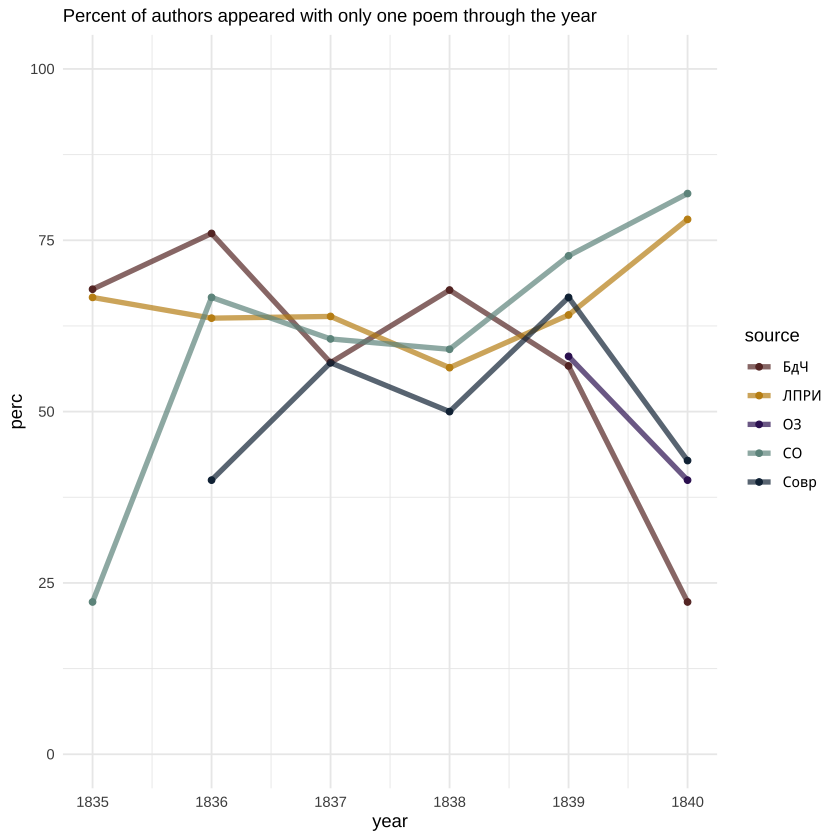

In [8]:
tibble(year = years,
       source = sources,
       perc = perc) %>% 
  mutate(perc = round(perc, 2)) %>% 
  pivot_wider(names_from = year, values_from = perc)


tibble(year = years,
       source = sources,
       perc = perc) %>% 
  ggplot(aes(x = year, y = perc, color = source)) + 
  geom_point() + 
  geom_line(linewidth = 1.5, alpha = 0.7) + 
  labs(subtitle = "Percent of authors appeared with only one poem through the year") + 
  scale_color_manual(values = c(met.brewer("Veronese")[1], # BdCH
              met.brewer("Veronese")[3], # LPRI
              met.brewer("Archambault")[2], # OZ
              met.brewer("Veronese")[4], # SO
              met.brewer("Veronese")[7])) + # Sovr 
  scale_y_continuous(limits = c(0,100))

In [13]:
ot_journals <- tibble(year = years,
       source = sources,
       perc = perc) %>%
  pivot_wider(names_from = source, values_from = perc)

ot_journals
summary(ot_journals)


tibble(year = years,
       source = sources,
       perc = perc) %>% summary(perc)

year,БдЧ,ЛПРИ,СО,Совр,ОЗ
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1835,67.85714,66.66667,22.22222,NaN,NaN
1836,76.00000,63.63636,66.66667,40.00000,NaN
1837,57.14286,63.88889,60.60606,57.14286,NaN
1838,67.74194,56.41026,59.09091,50.00000,NaN
1839,56.66667,64.10256,72.72727,66.66667,58.06452
1840,22.22222,78.04878,81.81818,42.85714,40.00000


      year           БдЧ             ЛПРИ             СО             Совр      
 Min.   :1835   Min.   :22.22   Min.   :56.41   Min.   :22.22   Min.   :40.00  
 1st Qu.:1836   1st Qu.:56.79   1st Qu.:63.70   1st Qu.:59.47   1st Qu.:42.86  
 Median :1838   Median :62.44   Median :64.00   Median :63.64   Median :50.00  
 Mean   :1838   Mean   :57.94   Mean   :65.46   Mean   :60.52   Mean   :51.33  
 3rd Qu.:1839   3rd Qu.:67.83   3rd Qu.:66.03   3rd Qu.:71.21   3rd Qu.:57.14  
 Max.   :1840   Max.   :76.00   Max.   :78.05   Max.   :81.82   Max.   :66.67  
                                                                NA's   :1      
       ОЗ       
 Min.   :40.00  
 1st Qu.:44.52  
 Median :49.03  
 Mean   :49.03  
 3rd Qu.:53.55  
 Max.   :58.06  
 NA's   :4      

      year         source               perc      
 Min.   :1835   Length:30          Min.   :22.22  
 1st Qu.:1836   Class :character   1st Qu.:56.41  
 Median :1838   Mode  :character   Median :60.61  
 Mean   :1838                      Mean   :58.33  
 3rd Qu.:1839                      3rd Qu.:66.67  
 Max.   :1840                      Max.   :81.82  
                                   NA's   :5      

### Intersection of top poets in different journals

Jaccard index for intersection over union. All poets from the same source are grouped together, the ones published 4 and more poems are included, then intersection between the lists of each journal is counted.

In [16]:
per %>% 
  filter(author != "" & per_cln %in% per_names) %>% 
  group_by(author, per_cln) %>% 
  count() %>% 
  ungroup() %>% 
  filter(n > 3) %>% 
  count(per_cln)

x <- per %>% 
  filter(author != "" & per_cln %in% per_names) %>% 
  group_by(author, per_cln) %>% 
  count() %>% 
  ungroup() %>% 
  filter(n > 3)

head(x)

per_cln,n
<chr>,<int>
БдЧ,23
ЛПРИ,27
ОЗ,12
СО,26
Совр,18


author,per_cln,n
<chr>,<chr>,<int>
***,БдЧ,4
***,СО,8
N.N.,ЛПРИ,4
Айбулат К.М.,ЛПРИ,13
Айбулат К.М.,ОЗ,4
Айбулат К.М.,Совр,10


In [18]:
source1 <- NULL
source2 <- NULL
a1 <- NULL
a2 <- NULL
sources <- NULL
intersections <- NULL
union <- NULL

for (i in 1:length(per_names)) {
  
  for (j in 1:length(per_names)) {
   
    source1 <- per_names[i]
    
    if (j == length(per_names)) {
      source2 <- per_names[1]
    } else {source2 <- per_names[j+1]}
    
    a1 <- x %>% 
      filter(per_cln == source1) %>% 
      select(author) %>% 
      distinct() %>% 
      pull()
     
    a2 <- x %>% 
      filter(per_cln == source2) %>% 
      select(author) %>% 
      distinct() %>% 
      pull()
    
    sources <- c(sources, paste0(source1, "__", source2))
    intersections <- c(intersections, length(intersect(a1, a2)))
    union <- c(union, length(union(a1, a2)))
    
  }
}

tibble(sources = sources, 
       int =  intersections, 
       union = union) %>% 
  mutate(jaccard = round(int/union, 3) ) %>% 
  select(sources, jaccard) %>% 
  separate(sources, into = c("s1", "s2"), sep = "__") %>% 
  pivot_wider(names_from = s2, values_from = jaccard) %>% 
  select(s1, БдЧ, ЛПРИ, СО, Совр, ОЗ)

s1,БдЧ,ЛПРИ,СО,Совр,ОЗ
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
БдЧ,1.000,0.136,0.167,0.108,0.029
ЛПРИ,0.136,1.000,0.178,0.125,0.114
СО,0.167,0.178,1.000,0.128,0.056
Совр,0.108,0.125,0.128,1.000,0.154
ОЗ,0.029,0.114,0.056,0.154,1.000


In [21]:
tibble(sources = sources, 
       int =  intersections, 
       union = union) %>% 
  mutate(jaccard = round(int/union, 3) ) %>% 
  select(sources, jaccard) %>% 
  filter(jaccard != 1) %>% 
  summary

   sources             jaccard      
 Length:20          Min.   :0.0290  
 Class :character   1st Qu.:0.1080  
 Mode  :character   Median :0.1265  
                    Mean   :0.1195  
                    3rd Qu.:0.1540  
                    Max.   :0.1780  

### Poets consecutively publishing in the same journal
Counting number of intersections between sets of authors in each journal in each consecutive pair of years.

In [ ]:
p <- NULL
y <- NULL

intersection <- NULL
total <- NULL

sources <- NULL
years <- NULL

for (i in 1:length(unique(per$year))) {
  
  y <- unique(per$year)[i]
  
  if (y < 1840) {

    for (j in 1:length(per_names)) {
      
      p <- per_names[j]
  
      authors_y1 <- per %>% 
        filter(per_cln == p & year == y & author != "") %>% 
        count(author) %>% pull(author)
  
      authors_y2 <- per %>% 
        filter(per_cln == p & year == y+1 & author != "") %>% 
        count(author) %>% pull(author)
      
      #intersect(authors_y1, authors_y2)
      
      sources <- c(sources, p)
      
      years <- c(years, paste0(y, " -> ", y+1))
      
      intersection <- c(intersection, length(intersect(authors_y1, authors_y2)))
      
      total <- c(total, length(c(authors_y1, authors_y2)))
      
      }
  } 
} 

tibble(sources = sources,
       years = years,
       int = intersection,
       total = total) %>% 
  mutate(jaccard = round(int/total, 3) ) %>% 
  #drop_na() %>% 
  select(sources, years, jaccard) %>% 
  pivot_wider(names_from = years, values_from = jaccard)

tibble(sources = sources,
       years = years,
       int = intersection,
       total = total) %>% 
  mutate(source = paste0(sources, "_", years)) %>% 
  filter(!source %in% c("Совр_1835 -> 1836", "ОЗ_1838 -> 1839")) %>% 
  mutate(jaccard = round(int/total, 3) ) %>% 
  drop_na() %>% 
  ggplot(aes(x = years, y = jaccard, color = sources, group = sources)) + 
    geom_point(size = 2) + 
    geom_line(linewidth = 2, alpha = 0.7) + 
    scale_y_continuous(limits = c(0, 1)) + 
    scale_color_manual(values = c(met.brewer("Veronese")[1], # BdCH
              met.brewer("Veronese")[3], # LPRI
              met.brewer("Archambault")[2], # OZ
              met.brewer("Veronese")[4], # SO
              met.brewer("Veronese")[7])) + 
  labs(color = "Источник",
       x = "Годы", 
       y = "Коэффициент пересечения (Жаккарда)") + 
  theme(legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14))

# ggsave(filename = "plots/fig_2-2-3.png", plot = last_plot(),
#        width = 8, height = 6, dpi = 300, bg = "white")

### LPRI genre titles

In [32]:
print("LPRI is the only source for these genres in all corpus:")
genres_legeres <- per %>% 
  #filter(PER_ID %in% c("ЛПРИ", "ЛГ")) %>% 
  filter(str_detect(text_title, 
                    "Шарада|Омоним|Анаграмма|Акростих|Логогриф|Эпиграмма|Загадка")) %>% 
  count(PER_ID, year) %>% 
  mutate(id = paste0(PER_ID, "_", year)) 

print(genres_legeres)

per %>% 
  #filter(PER_ID %in% c("ЛПРИ", "ЛГ")) %>% 
  filter(str_detect(text_title, 
                    "шарада|омоним|анаграмма|акростих|логогриф|эпиграмма|загадка")) %>% 
  count(PER_ID, year)

per %>% 
  #filter(PER_ID %in% c("ЛПРИ", "ЛГ")) %>% 
  filter(str_detect(subtitle, 
                    "Шарада|Омоним|Анаграмма|Акростих|Логогриф|Эпиграмма|Загадка")) %>% 
  count(PER_ID, year)

[1] "LPRI is the only source for these genres in all corpus:"
  PER_ID year  n         id
1   ЛПРИ 1835 48  ЛПРИ_1835
2   ЛПРИ 1836 42  ЛПРИ_1836
3  СОиСА 1835  1 СОиСА_1835


PER_ID,year,n
<chr>,<int>,<int>
ЛПРИ,1836,7


PER_ID,year,n
<chr>,<int>,<int>
ЛГ,1840,1


In [33]:
print("Total number of poems in LPRI in 1835-1836")
per %>% 
  filter(PER_ID == "ЛПРИ") %>% 
  count(PER_ID, year) %>% 
  rename(total = n) %>% 
  mutate(id = paste0(PER_ID, "_", year)) %>% 
  select(id, total) %>% 
  inner_join(genres_legeres %>% select(id, n), by = "id") %>% 
  mutate(perc = round((n/total)*100, 1) )

[1] "Total number of poems in LPRI in 1835-1836"


id,total,n,perc
<chr>,<int>,<int>,<dbl>
ЛПРИ_1835,154,48,31.2
ЛПРИ_1836,111,42,37.8


## 2.2.2 Female poetry in journals

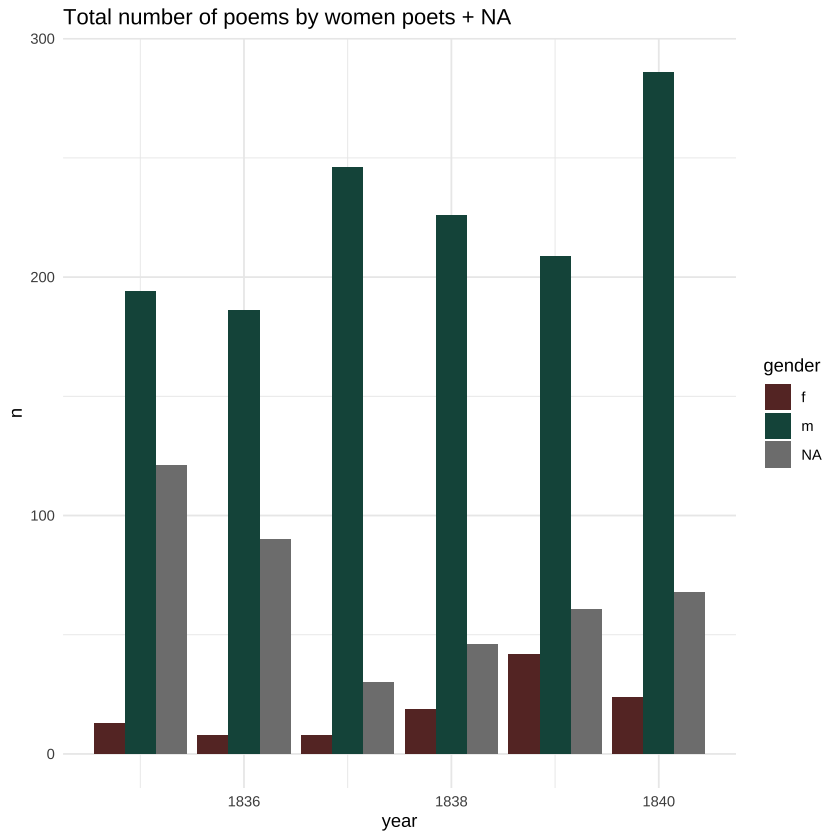

In [42]:
per %>% 
  count(year, gender) %>% 
  #drop_na() %>% 
  ggplot(aes(x = year, y = n, fill = gender)) + 
    geom_col(position = "dodge") + 
    labs(title = "Total number of poems by women poets + NA") + 
    scale_fill_manual(values = c(met.brewer("Veronese")[1],
                                met.brewer("Veronese")[6],
                                met.brewer("Veronese")[5]))

Number of women's poems published in each journal in each year

In [31]:
per %>% 
  group_by(per_cln) %>% 
  count(year, gender) %>% 
  drop_na() %>% 
  pivot_wider(names_from = year, values_from = n, values_fill = 0 ) %>% 
  mutate(total = rowSums(across(where(is.numeric)))) 

totals <- per %>% 
    count(per_cln) %>% 
    rename(total_source = n)

per %>% 
  group_by(per_cln) %>% 
  count(year, gender) %>% 
  drop_na() %>% 
  pivot_wider(names_from = year, values_from = n, values_fill = 0 ) %>% 
  mutate(total_fem = rowSums(across(where(is.numeric)))) %>% 
  filter(gender == "f") %>%
  left_join(totals, by = "per_cln") %>%
  mutate(perc_fem = round( (total_fem/total_source)*100, 1 ))


per_cln,gender,1835,1836,1837,1838,1839,1840,total
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
БдЧ,f,1,4,3,6,2,0,16
БдЧ,m,61,43,62,48,47,44,305
ЛПРИ,f,2,0,3,3,7,1,16
ЛПРИ,m,67,58,60,80,44,33,342
МН,f,10,4,0,0,0,0,14
МН,m,25,34,0,0,0,0,59
ОЗ,f,0,0,0,0,20,6,26
ОЗ,m,0,0,0,0,56,97,153
ПРиВЕТ,f,0,0,0,0,0,5,5


per_cln,gender,1835,1836,1837,1838,1839,1840,total_fem,total_source,perc_fem
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>
БдЧ,f,1,4,3,6,2,0,16,365,4.4
ЛПРИ,f,2,0,3,3,7,1,16,574,2.8
МН,f,10,4,0,0,0,0,14,94,14.9
ОЗ,f,0,0,0,0,20,6,26,181,14.4
ПРиВЕТ,f,0,0,0,0,0,5,5,73,6.8
СО,f,0,0,0,5,5,2,12,310,3.9
Сев_пч,f,0,0,0,1,0,0,1,15,6.7
Совр,f,0,0,2,4,8,10,24,236,10.2


In [44]:
print(c("Total number of poems written by women poets in periodicals:", 
      per %>% filter(gender == "f") %>% nrow ) )

per %>% 
  filter(gender == "f") %>% 
  count(author, sort = T) %>% 
  mutate(perc = round((n/114)*100, 2))

[1] "Total number of poems written by women poets in periodicals:"
[2] "114"                                                         


author,n,perc
<chr>,<int>,<dbl>
Ростопчина Е.П.,45,39.47
Павлова К.К.,16,14.04
Теплова Н.С.,14,12.28
Шахова Е.Н.,13,11.40
Волконская З.А.,5,4.39
Аладьина Е.В.,3,2.63
Макшеева В.Д.,3,2.63
Афанасьева А.,2,1.75
Корсакова Л.,2,1.75
